### Imports

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import optuna
import pandas as pd
import seaborn as sns
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

import sys
sys.path.append("../../") # Add parent directory to sys.path to access preprocessing module
sys.path.append("../") # Add parent directory to sys.path to access preprocessing module

from preprocessing.data_augmentor import DataAugmentor
from preprocessing.feature_extractor import FeatureExtractor
from preprocessing.sampler import Sampler

## Data Preparation

In [2]:
data_dir = "../../data/Composer_Dataset"
composers = ["Bach", "Beethoven", "Chopin", "Mozart"]
scalar_features, multidimensional_features = FeatureExtractor.extract_features_for_directory(data_dir, composers)

Loading existing features from ../../data/Composer_Dataset/extracted_features.pkl


In [3]:
scalar_features.head()

,max_independent_voices,avg_independent_voices,var_independent_voices,avg_simultaneity,var_simultaneity,note_density,avg_note_duration,var_note_duration,initial_tempo,time_signature_numerator,...,perfect_vertical_intervals,vertical_minor_seconds,vertical_thirds,vertical_fifths,vertical_tritones,vertical_octaves,avg_chord_duration,length,file_name,composer
0,4.0,3.899642,0.300477,3.720000,1.020588,6.439026,0.621212,0.296121,143.000038,4.0,...,0.391195,0.000000,0.327044,0.200000,0.045283,0.122013,0.465000,29.999992,042100b_.mid,Bach
1,4.0,3.986667,0.114698,3.600000,1.200000,7.394595,0.526316,0.250579,189.176471,4.0,...,0.400447,0.005220,0.307979,0.168531,0.042506,0.123788,0.321429,25.000000,043100b_.mid,Bach
2,7.0,2.664012,1.617631,2.331998,1.816512,6.292553,0.371665,0.686803,181.905446,4.0,...,0.378734,0.006634,0.291590,0.120602,0.057594,0.158185,0.177695,923.701235,Bwv0564-Toccata-Adagio-and-Fugue.mid,Bach
3,4.0,3.970874,0.168160,3.662222,1.112213,8.775758,0.455801,0.212811,177.509434,4.0,...,0.375205,0.009852,0.312808,0.130542,0.030378,0.115764,0.321875,22.500000,027400b_.mid,Bach
4,4.0,3.917323,0.275394,3.455782,1.371385,5.195127,0.713614,0.442007,153.000153,4.0,...,0.478439,0.002738,0.309377,0.206023,0.016427,0.140999,0.470370,29.333304,026400b_.mid,Bach


In [4]:
print(f"Piano Roll Shape: {multidimensional_features[0]['piano_roll'].shape}")
print(f"Chroma Piano Roll Shape: {multidimensional_features[0]['chroma_piano_roll'].shape}")
print(f"Pitch Class Histogram Shape: {multidimensional_features[0]['pitch_class_histogram'].shape}")
print(f"Pitch Class Transition Matrix Shape: {multidimensional_features[0]['pitch_class_transition_matrix'].shape}")

Piano Roll Shape: (128, 299)
Chroma Piano Roll Shape: (12, 299)
Pitch Class Histogram Shape: (12,)
Pitch Class Transition Matrix Shape: (12, 12)


### Train Val Test Split

Data was split with an 80/10/10 train/val/test split.

In [5]:
y = scalar_features['composer']
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)

scalar_train, scalar_holdout, multidim_train, multidim_holdout, y_train, y_holdout = Sampler.split_data(scalar_features, multidimensional_features, y, test_size=0.2, random_state=1)

scalar_val, scalar_test, multidim_val, multidim_test, y_val, y_test = Sampler.split_data(scalar_holdout, multidim_holdout, y_holdout, test_size=0.5, random_state=1)

train_composer_files = scalar_train[['composer', 'file_name']]
scalar_features = scalar_features.drop('file_name', axis=1)
scalar_train.drop(['composer', 'file_name'], axis=1, inplace=True)
scalar_val.drop(['composer', 'file_name'], axis=1, inplace=True)
scalar_test.drop(['composer', 'file_name'], axis=1, inplace=True)

/var/folders/v3/6g8j12qj0yd6zlbh6nr578p80000gn/T/ipykernel_93273/2216297816.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  scalar_val.drop(['composer', 'file_name'], axis=1, inplace=True)
/var/folders/v3/6g8j12qj0yd6zlbh6nr578p80000gn/T/ipykernel_93273/2216297816.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  scalar_test.drop(['composer', 'file_name'], axis=1, inplace=True)


{'Bach': 815, 'Mozart': 215, 'Beethoven': 176, 'Chopin': 102}


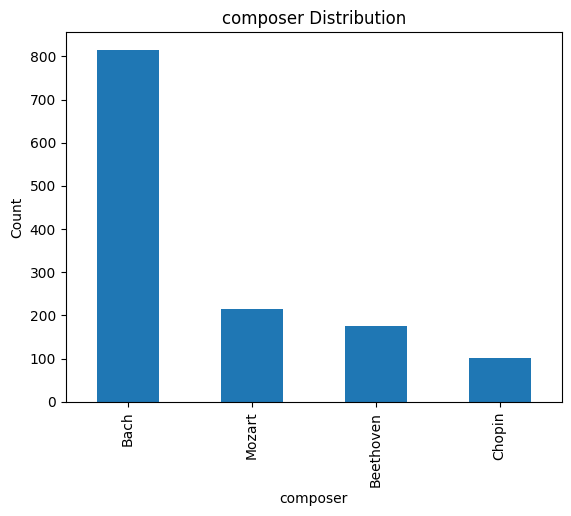

In [6]:
def plot_column_distribution(data: pd.DataFrame, column: str) -> None:
    print(dict(data[column].value_counts()))
    data[column].value_counts().plot(kind='bar')
    plt.title(f'{column} Distribution')
    plt.xlabel(f'{column}')
    plt.ylabel(f'Count')
    plt.show()
    
train_composers = pd.DataFrame(label_encoder.inverse_transform(y_train), columns=['composer'])
plot_column_distribution(train_composers, 'composer')

{'Mozart': 815, 'Bach': 815, 'Beethoven': 815, 'Chopin': 815}


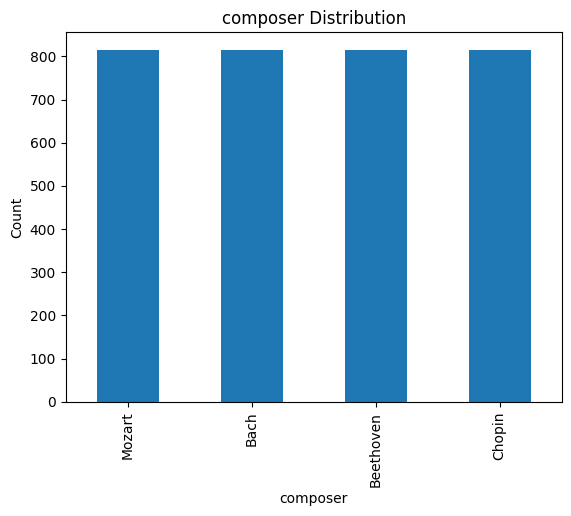

In [7]:
scalar_train, multidim_train, y_train = Sampler.oversample_balance(scalar_train, multidim_train, y_train)
train_composers = pd.DataFrame(label_encoder.inverse_transform(y_train), columns=['composer'])
plot_column_distribution(train_composers, 'composer')

In [8]:
num_augmented_songs = 100
mozart_aug_scalars, mozart_aug_multidim = DataAugmentor.generate_augmented_songs(data_dir, train_composer_files[train_composer_files['composer'] == 'Mozart'], num_augmented_songs)
bach_aug_scalars, bach_aug_multidim = DataAugmentor.generate_augmented_songs(data_dir, train_composer_files[train_composer_files['composer'] == 'Bach'], num_augmented_songs)
beethoven_aug_scalars, beethoven_aug_multidim = DataAugmentor.generate_augmented_songs(data_dir, train_composer_files[train_composer_files['composer'] == 'Beethoven'], num_augmented_songs)
chopin_aug_scalars, chopin_aug_multidim = DataAugmentor.generate_augmented_songs(data_dir, train_composer_files[train_composer_files['composer'] == 'Chopin'], num_augmented_songs)

scalar_train = pd.concat([scalar_train, mozart_aug_scalars, bach_aug_scalars, beethoven_aug_scalars, chopin_aug_scalars], axis=0)
multidim_train = multidim_train + mozart_aug_multidim + bach_aug_multidim + beethoven_aug_multidim + chopin_aug_multidim

Generating Augmented Songs:   0%|          | 0/100 [00:00<?, ?song/s]/Users/kdevoe/Documents/CS/Masters/AAI511/ms-aai-511-final-project/511_final_env/lib/python3.10/site-packages/numpy/lib/histograms.py:1124: RuntimeWarning: invalid value encountered in divide
  hist /= s
Generating Augmented Songs:  24%|██▍       | 24/100 [01:23<05:02,  3.98s/song]/Users/kdevoe/Documents/CS/Masters/AAI511/ms-aai-511-final-project/511_final_env/lib/python3.10/site-packages/pretty_midi/pretty_midi.py:100: RuntimeWarning: Tempo, Key or Time signature change events found on non-zero tracks.  This is not a valid type 0 or type 1 MIDI file.  Tempo, Key or Time Signature may be wrong.
  warnings.warn(
Generating Augmented Songs: 100%|██████████| 100/100 [01:27<00:00,  1.15song/s]


In [9]:
mozart_aug_y = np.full(num_augmented_songs, label_encoder.transform(['Mozart']))
bach_aug_y = np.full(num_augmented_songs, label_encoder.transform(['Bach']))
beethoven_aug_y = np.full(num_augmented_songs, label_encoder.transform(['Beethoven']))
chopin_aug_y = np.full(num_augmented_songs, label_encoder.transform(['Chopin']))
y_train = np.hstack((y_train, mozart_aug_y, bach_aug_y, beethoven_aug_y, chopin_aug_y))

{'Mozart': 915, 'Bach': 915, 'Beethoven': 915, 'Chopin': 915}


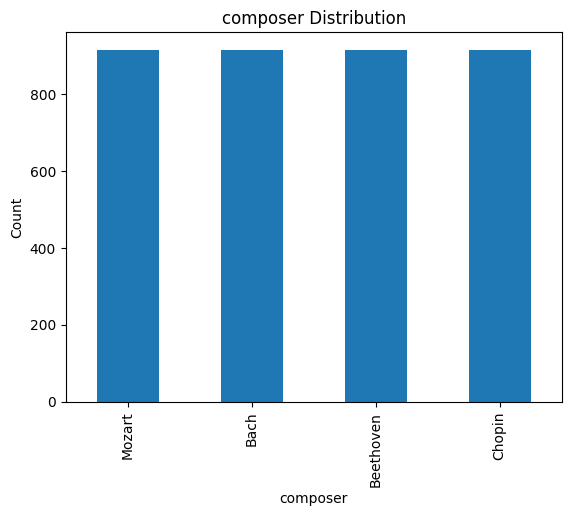

In [10]:
train_composers = pd.DataFrame(label_encoder.inverse_transform(y_train), columns=['composer'])
plot_column_distribution(train_composers, 'composer')

### Chunk Into Sequences

Sequence chunking was done to fix the size of the inputs to the model. A side benefit of chunking sequences is that it increases the number of samples in the dataset.

In [11]:
def chunk_sequences(X_in, y_in, feature, sequence_length=100):
    X_out = []
    y_out = []

    # make sequences split along the time axis
    for i in range(len(X_in)):
        for j in range(0, len(X_in[i][feature][1]) - sequence_length, sequence_length):
            X_out.append(X_in[i][feature][:, j:j + sequence_length])
            y_out.append(y_in[i])

    return X_out, y_out

### Make Dataloader

A dataloader class was used to efficiently batch the data for processing by the model.

In [12]:
class PianoRollDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        X = torch.tensor(self.X[idx], dtype=torch.float32) 
        y = torch.tensor(self.y[idx], dtype=torch.long)
        return X, y

## Convolutional Neural Network (CNN)

A CNN was trained to take the multi-dimensional song data and predict the composer of the work. To fully utilize all the available data after the CNN was trained the outputs were fed into a separate classifier along with scalar features to predict the composer.

### Dataloaders

Dataloaders from PyTorch were used to load data in batches for training and evaluating the CNN model. The get_dataloaders function will generate dataloaders for the training, validation, and test sets.

In [13]:
def get_dataloaders(use_chroma, seq_length=100, batch_size=8):
    
    # Set random seed for PyTorch
    torch.manual_seed(42) 
    
    feature_set = 'chroma_piano_roll' if use_chroma else 'piano_roll'

    X_train_seq, y_train_seq = chunk_sequences(multidim_train, y_train, feature_set, seq_length)
    X_val_seq, y_val_seq = chunk_sequences(multidim_val, y_val, feature_set, seq_length)
    X_test_seq, y_test_seq = chunk_sequences(multidim_test, y_test, feature_set, seq_length)

    train_dataset = PianoRollDataset(X_train_seq, y_train_seq)
    val_dataset = PianoRollDataset(X_val_seq, y_val_seq)
    test_dataset = PianoRollDataset(X_test_seq, y_test_seq)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    return train_loader, val_loader, test_loader

### Define CNN Model

The overall architecture of the CNN model was kept simple, with 2 convolutional / pooling layers followed by two fully connected layers. The output of the CNN model is four values, one for each composer, which are used for multi-class classification between the four composers.

In [14]:
class PianoRollCNN(nn.Module):
    def __init__(self, h_params):
        super(PianoRollCNN, self).__init__()

        input_channels = 12 if h_params['use_chroma'] else 128

        self.conv1 = nn.Conv1d(input_channels, h_params['conv1_out_channels'], 
                               kernel_size=h_params['kernel_size'], stride=h_params['stride'], 
                               padding=h_params['kernel_size'] // 2)
        self.conv2 = nn.Conv1d(h_params['conv1_out_channels'], h_params['conv2_out_channels'], 
                               kernel_size=h_params['kernel_size'], stride=h_params['stride'],
                               padding=h_params['kernel_size'] // 2)
        self.pool = nn.MaxPool1d(kernel_size=h_params['pool_kernel_size'], stride=h_params['pool_stride'], padding=0)

        def conv_output_size(input_size, kernel_size, stride, padding):
            return (input_size - kernel_size + 2 * padding) // stride + 1
    
        padding = h_params['kernel_size'] // 2  # Assuming same padding

        # First conv layer output size
        conv1_output_width = conv_output_size(int(h_params['seq_length']), h_params['kernel_size'], h_params['stride'], padding)
        # First pooling layer output size
        pooled_width = conv_output_size(conv1_output_width, h_params['pool_kernel_size'], h_params['pool_stride'], 0)
        # Second conv layer output size
        conv2_output_width = conv_output_size(pooled_width, h_params['kernel_size'], h_params['stride'], padding)
        # Second pooling layer output size
        pooled_width = conv_output_size(conv2_output_width, h_params['pool_kernel_size'], h_params['pool_stride'], 0)

        self.fc1 = nn.Linear(h_params['conv2_out_channels'] * pooled_width, h_params['fc1_out'])
        self.dropout = nn.Dropout(h_params['dropout'])
        self.fc2 = nn.Linear(h_params['fc1_out'], 4)  # Output of 4 classes (composers)

    def forward(self, x):
        x = x.squeeze(2) 
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(x.size(0), -1) 
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.fc2(x)
        return x

### Define Training Loop

In [39]:
def train_cnn(model, train_loader, val_loader, num_epochs, criterion, optimizer, silent=False):

    train_losses = []
    val_losses = []

    for epoch in range(num_epochs):

        # Training
        model.train()
        running_loss = 0.0
        report_interval = 1000

        for i, data in enumerate(train_loader):
            inputs, labels = data
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            train_losses.append(loss.item())
            if i % report_interval == (report_interval - 1) and not silent:
                print(f'[Epoch {epoch + 1}, Batch {i + 1}] loss: {running_loss / report_interval:.3f}')
                running_loss = 0.0  # Reset running loss

        # Validation
        model.eval()
        val_loss = 0.0
        correct = 0
        total = 0
        with torch.no_grad():
            for data in val_loader:
                inputs, labels = data
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        if not silent:
            print(f'Validation loss: {val_loss / len(val_loader):.3f}, Accuracy: {100 * correct / total:.2f}%')

    if not silent:
        # Plot training losses
        plt.plot(train_losses)
        plt.title('Training Loss')
        plt.xlabel('Batch')
        plt.ylabel('Loss')
        plt.show()

### Evaluate Performance

In [43]:
def evaluate_performance(model, data_loader, silent=False):
    model.eval()

    all_labels = []
    all_predictions = []

    # Disable gradient computation for evaluation
    with torch.no_grad():
        for data in data_loader:
            inputs, labels = data
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)

            # Store true and predicted labels
            all_labels.extend(labels.numpy())
            all_predictions.extend(predicted.numpy())

    # Compute the classification report
    report = pd.DataFrame(classification_report(all_labels, all_predictions, target_names=label_encoder.classes_, output_dict=True)).T
    report = report.round(2)

    if not silent:
        display(report)

    return report, all_labels, all_predictions

### Define Training Run

A single training run for the model with a given set of hyperparameters to test.

In [17]:
def training_run(h_params, silent=False):

    seq_length = int(h_params['seq_length'])
    batch_size = int(h_params['batch_size'])

    train_loader, val_loader, test_loader = get_dataloaders(h_params['use_chroma'], seq_length, batch_size)

    model = PianoRollCNN(h_params)

    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=h_params['lr'])
    train_cnn(model, train_loader, val_loader, h_params['num_epochs'], criterion, optimizer, silent)

    return model, val_loader

### Hyperparameter Search via Optuna Library

Hyperparameters and ranges were experimentally determined through several initial trials to find reasonable ranges for the hyperparameters. The Optuna library was then used to search for the best hyperparameters within these ranges.

In [18]:
def objective(trial):
    # Define the hyperparameter search space
    h_params = {
        'use_chroma': False,
        'seq_length': trial.suggest_int('seq_length', 20, 100),
        'batch_size': trial.suggest_int('batch_size', 2, 64),
        'lr': trial.suggest_float('lr', 1e-5, 1e-2, log=True),
        'num_epochs': 3,
        'conv1_out_channels': trial.suggest_int('conv1_out_channels', 16, 64),
        'conv2_out_channels': trial.suggest_int('conv2_out_channels', 32, 128),
        'kernel_size': trial.suggest_int('kernel_size', 3, 9),
        'stride': 1,
        'pool_kernel_size': 2,
        'pool_stride': 2,
        'dropout': trial.suggest_float('dropout', 0.0, 0.5),
        'fc1_out': trial.suggest_int('fc1_out', 64, 256)
    }

    model, val_loader = training_run(h_params, silent=True)
    report, _, _ = evaluate_performance(model, val_loader, silent=True)

    return float(report.split('\n')[7].split()[1])  # Return validation accuracy

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)  # Run 50 trials to optimize the validation accuracy

print("Best Parameters: ", study.best_params)
print("Best Accuracy: ", study.best_value)

[I 2024-08-06 22:41:40,559] A new study created in memory with name: no-name-643e0720-4c23-4886-afa4-bc19e5a7b011
[I 2024-08-06 23:04:45,694] Trial 0 finished with value: 0.59 and parameters: {'seq_length': 31, 'batch_size': 23, 'lr': 4.196938940115864e-05, 'conv1_out_channels': 36, 'conv2_out_channels': 44, 'kernel_size': 7, 'dropout': 0.37513971177994393, 'fc1_out': 115}. Best is trial 0 with value: 0.59.
[I 2024-08-06 23:20:25,190] Trial 1 finished with value: 0.57 and parameters: {'seq_length': 52, 'batch_size': 55, 'lr': 0.0014886228293304808, 'conv1_out_channels': 43, 'conv2_out_channels': 92, 'kernel_size': 6, 'dropout': 0.1453869731295206, 'fc1_out': 86}. Best is trial 0 with value: 0.59.
[I 2024-08-06 23:30:14,292] Trial 2 finished with value: 0.63 and parameters: {'seq_length': 62, 'batch_size': 22, 'lr': 0.00011768048294869942, 'conv1_out_channels': 18, 'conv2_out_channels': 89, 'kernel_size': 3, 'dropout': 0.40376873830416604, 'fc1_out': 73}. Best is trial 2 with value: 0.6

Best Parameters:  {'seq_length': 83, 'batch_size': 64, 'lr': 0.000318541271307236, 'conv1_out_channels': 54, 'conv2_out_channels': 114, 'kernel_size': 8, 'dropout': 0.19512096269338727, 'fc1_out': 148}
Best Accuracy:  0.69


### Single Training Run

A single training run was performed with the best parameters found from the hyperparameter search.

[Epoch 1, Batch 1000] loss: 0.962
[Epoch 1, Batch 2000] loss: 0.665
Validation loss: 0.935, Accuracy: 65.65%
[Epoch 2, Batch 1000] loss: 0.461
[Epoch 2, Batch 2000] loss: 0.387
Validation loss: 0.970, Accuracy: 68.08%
[Epoch 3, Batch 1000] loss: 0.271
[Epoch 3, Batch 2000] loss: 0.252
Validation loss: 1.221, Accuracy: 68.64%
[Epoch 4, Batch 1000] loss: 0.179
[Epoch 4, Batch 2000] loss: 0.189
Validation loss: 1.443, Accuracy: 67.30%
[Epoch 5, Batch 1000] loss: 0.128
[Epoch 5, Batch 2000] loss: 0.141
Validation loss: 1.564, Accuracy: 68.84%


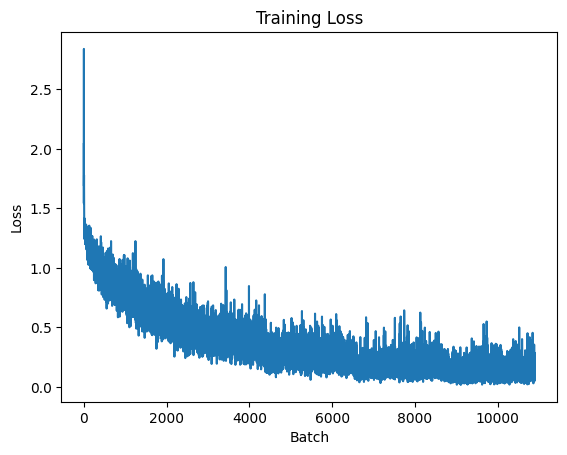

              precision    recall  f1-score      support
Bach           0.840761  0.813218  0.826760  1740.000000
Beethoven      0.501403  0.601571  0.546939   891.000000
Chopin         0.640845  0.629758  0.635253   289.000000
Mozart         0.655750  0.602519  0.628009  1429.000000
accuracy       0.688434  0.688434  0.688434     0.688434
macro avg      0.659690  0.661767  0.659240  4349.000000
weighted avg   0.697159  0.688434  0.691400  4349.000000


In [40]:
test_params = {}

# Set all the hyperparameters to the best values found during optimization
for key, value in study.best_params.items():
    test_params[key] = value

test_params['use_chroma'] = False
test_params['num_epochs'] = 5
test_params['stride'] = 1
test_params['pool_kernel_size'] = 2
test_params['pool_stride'] = 2

model, test_dataloader = training_run(test_params, silent=False)

The base CNN model shows an overall accuracy of 69% with balanced precision and recall. Overall Bach is the most accuractely predicted composer, following the number of examples in the dataset.

In [44]:
report, _, _ = evaluate_performance(model, test_dataloader)

,precision,recall,f1-score,support
Bach,0.84,0.81,0.83,1740.00
Beethoven,0.50,0.60,0.55,891.00
Chopin,0.64,0.63,0.64,289.00
Mozart,0.66,0.60,0.63,1429.00
accuracy,0.69,0.69,0.69,0.69
macro avg,0.66,0.66,0.66,4349.00
weighted avg,0.70,0.69,0.69,4349.00


### Combine CNN Predictions with Scalar Features for Classification

To take advantage of the scalar features in the dataset a separate classifier was trained to predict the composer based on the output of the CNN model and the scalar features. The scalar features were concatenated with the output of the CNN model and fed into a fully connected neural network to predict the composer.

Given a single input track make a prediction for each composer using the CNN classifier.

In [20]:
def get_prediction(X_in, feature, sequence_length=100):
    X_sequences = []

    # make sequences split along the time axis
    for j in range(0, len(X_in[feature][1]) - sequence_length, sequence_length):
        X_sequences.append(X_in[feature][:, j:j + sequence_length])
    
    predictions = []

    for i in range(len(X_sequences)):
        inputs = torch.tensor(X_sequences[i], dtype=torch.float32)
        outputs = model(inputs.unsqueeze(0))
        predictions.append(outputs.tolist())

    # Average the prediction values across the sequences
    predictions = torch.tensor(predictions).mean(dim=0)

    return predictions.tolist()[0]

### Add CNN Outputs to Scalar Features

Concatenate CNN predictions into the scalar features to later be input into the classifier.

In [21]:
def add_cnn_predictions(multidimensional_features, scalar_features, feature, sequence_length=100):

    # Use the index list of scalar_features to add cnn predictions to correct rows
    index_list = scalar_features.index.tolist()

    for i, md_row in enumerate(multidimensional_features):
        predictions = get_prediction(md_row, feature, sequence_length)
        for idx, prediction in enumerate(predictions):
            column = "composer_" + str(idx)
            scalar_features.loc[index_list[i], column] = prediction

In [22]:
cnn_scalar_train = scalar_train.copy()
add_cnn_predictions(multidim_train, cnn_scalar_train, 'piano_roll', study.best_params['seq_length'])


cnn_scalar_test = scalar_test.copy()
add_cnn_predictions(multidim_test, cnn_scalar_test, 'piano_roll', study.best_params['seq_length'])

### Run Classifier Using CNN Predictions and Scalar Features

In [23]:
classifier = HistGradientBoostingClassifier(random_state=1)
classifier.fit(cnn_scalar_train, y_train)

HistGradientBoostingClassifier(random_state=1)

Once a classifier was used with both CNN outputs and scalar features the accuracy increased significantly to 85% overall.

In [37]:
y_pred = classifier.predict(cnn_scalar_test)
print("Classification Report:")

report = classification_report(y_test, y_pred, target_names=label_encoder.classes_, output_dict=True)
report = pd.DataFrame(report).transpose()
report = report.round(2)
display(report)

Classification Report:


,precision,recall,f1-score,support
Bach,0.90,0.98,0.94,101.00
Beethoven,0.64,0.64,0.64,22.00
Chopin,1.00,0.64,0.78,22.00
Mozart,0.72,0.68,0.70,19.00
accuracy,0.85,0.85,0.85,0.85
macro avg,0.81,0.73,0.76,164.00
weighted avg,0.86,0.85,0.85,164.00


### Fine Tune Classifier

Using the sklearn library's GridSearchCV function the hyperparameters of the classifier were fine tuned to increase the accuracy of the model.

In [25]:
# Define the hyperparameter grid
param_grid = {
    'learning_rate': [0.01, 0.1, 0.2],
    'max_iter': [100, 200, 300],
    'max_leaf_nodes': [31, 50, 100],
    'max_depth': [3, 5, 7],
}

In [26]:
from sklearn.model_selection import GridSearchCV

# Initialize the classifier
hgb_clf = HistGradientBoostingClassifier(random_state=42)

# Set up the GridSearchCV
grid_search = GridSearchCV(estimator=hgb_clf, param_grid=param_grid, 
                           scoring='accuracy', cv=5, n_jobs=-1, verbose=0)

# Fit the grid search to the data
grid_search.fit(cnn_scalar_train, y_train)

GridSearchCV(cv=5, estimator=HistGradientBoostingClassifier(random_state=42),
             n_jobs=-1,
             param_grid={'learning_rate': [0.01, 0.1, 0.2],
                         'max_depth': [3, 5, 7], 'max_iter': [100, 200, 300],
                         'max_leaf_nodes': [31, 50, 100]},
             scoring='accuracy')

In [45]:
# Get the best parameters and best score
best_params = grid_search.best_params_
best_score = grid_search.best_score_

print("Best Hyperparameters:", best_params)
print("Best Cross-Validated Score:", best_score)

# Evaluate on the test set
best_model = grid_search.best_estimator_
test_score = best_model.score(cnn_scalar_test, y_test)
print("Test Set Accuracy:", test_score)

# Generate Classification Report

y_pred = best_model.predict(cnn_scalar_test)
print("\n---- Classification Report After Tuning ----\n")
report2 = classification_report(y_test, y_pred, target_names=label_encoder.classes_, output_dict=True)
report2 = pd.DataFrame(report2).transpose()
report2 = report2.round(2)
display(report2)

Best Hyperparameters: {'learning_rate': 0.1, 'max_depth': 3, 'max_iter': 300, 'max_leaf_nodes': 31}
Best Cross-Validated Score: 0.9387978142076504
Test Set Accuracy: 0.8841463414634146

---- Classification Report After Tuning ----



,precision,recall,f1-score,support
Bach,0.91,0.98,0.94,101.00
Beethoven,0.76,0.73,0.74,22.00
Chopin,0.94,0.73,0.82,22.00
Mozart,0.82,0.74,0.78,19.00
accuracy,0.88,0.88,0.88,0.88
macro avg,0.86,0.79,0.82,164.00
weighted avg,0.88,0.88,0.88,164.00


## Long Short Term Memory Neural Network (LSTM)

### Chunk Into Sequences

In [47]:
def chunk_sequences(X_in, y_in, feature, sequence_length=100):
    X_out = []
    y_out = []

    # Make sure you are slicing along the time axis
    for i in range(len(X_in)):
        feature_matrix = X_in[i][feature]
        num_time_steps = feature_matrix.shape[1]
        
        for j in range(0, num_time_steps - sequence_length, sequence_length):
            X_out.append(feature_matrix[:, j:j + sequence_length].T)  # Transpose to (sequence_length, feature_dim)
            y_out.append(y_in[i])

    return X_out, y_out

### Define LSTM

Long short-term memory is a type of recurrent neural network aimed at dealing with the vanishing gradient problem present in traditional RNNs. Its relative insensitivity to gap length is its advantage over other RNNs, hidden Markov models and other sequence learning methods. The LSTM was trained to take multi-dimensional data and predict the composer of each song in the data file. After LSTM training the outputs were fed into a separate classifier along with scalar features to predict the composer optimally.

In [55]:
class PianoRollLSTM(nn.Module):
    def __init__(self, h_params):
        super(PianoRollLSTM, self).__init__()

        self.h_params = h_params  # Store h_params in the class
        input_size = 12 if h_params['use_chroma'] else 128
        hidden_size = h_params['hidden_size']
        num_layers = h_params['num_layers']
        
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=h_params['dropout'])
        self.fc = nn.Linear(hidden_size, 4)  # Output of 4 classes (composers)

    def forward(self, x):
        # Forward pass through LSTM
        h0 = torch.zeros(self.h_params['num_layers'], x.size(0), self.h_params['hidden_size']).to(x.device)
        c0 = torch.zeros(self.h_params['num_layers'], x.size(0), self.h_params['hidden_size']).to(x.device)
        out, _ = self.lstm(x, (h0, c0))
        # Take the output of the last time step
        out = self.fc(out[:, -1, :])
        return out

## Training LSTM

In [57]:
def train_lstm(model, train_loader, val_loader, num_epochs, criterion, optimizer, silent=False):

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        report_interval = 1000
        for i, data in enumerate(train_loader):
            inputs, labels = data
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            if i % report_interval == (report_interval - 1) and not silent:
                print(f'[Epoch {epoch + 1}, Batch {i + 1}] loss: {running_loss / report_interval:.3f}')
                running_loss = 0.0

        model.eval()
        val_loss = 0.0
        correct = 0
        total = 0
        with torch.no_grad():
            for data in val_loader:
                inputs, labels = data
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        if not silent:
            print(f'Validation loss: {val_loss / len(val_loader):.3f}, Accuracy: {100 * correct / total:.2f}%')

## Hyperparaameter Search Via Optuna Library

In [86]:
def objective(trial):
    h_params = {
        'hidden_size': trial.suggest_int('hidden_size', 32, 128),
        'num_layers': trial.suggest_int('num_layers', 1, 3),
        'dropout': trial.suggest_uniform('dropout', 0.1, 0.5),
        'num_epochs': trial.suggest_int('num_epochs', 1, 5),
        'batch_size': trial.suggest_categorical('batch_size', [8, 16, 32]),
        'learning_rate': trial.suggest_loguniform('learning_rate', 1e-5, 1e-1),
        'use_chroma': trial.suggest_categorical('use_chroma', [True, False]),
        'seq_length': trial.suggest_int('seq_length', 50, 150)
    }
    
    train_loader, val_loader, _ = get_dataloaders(h_params['use_chroma'], seq_length=100, batch_size=h_params['batch_size'])

    model = PianoRollLSTM(h_params)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=h_params['learning_rate'])

    train_lstm(model, train_loader, val_loader, h_params['num_epochs'], criterion, optimizer, silent=True)
    
    val_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for data in val_loader:
            inputs, labels = data
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    print(f"\nTrial results: Loss = {val_loss / len(val_loader):.3f}, Accuracy = {accuracy:.2f}%")
    return accuracy

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=10)

print("\nBest Trial:")
print(f"Best Parameters: {study.best_trial.params}")
print(f"Best Value: {study.best_value}")

[I 2024-08-09 18:35:32,910] A new study created in memory with name: no-name-7c4e17fc-b1e1-4a8a-9d25-631554f836e4
C:\Users\sassy\AppData\Local\Temp\ipykernel_10896\3600206045.py:5: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'dropout': trial.suggest_uniform('dropout', 0.1, 0.5),
C:\Users\sassy\AppData\Local\Temp\ipykernel_10896\3600206045.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-5, 1e-1),
C:\Users\sassy\anaconda3\Lib\site-packages\torch\nn\modules\rnn.py:88: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.40348426


Trial results: Loss = 1.574, Accuracy = 29.00%


[I 2024-08-09 18:46:16,003] Trial 1 finished with value: 67.90611201487334 and parameters: {'hidden_size': 87, 'num_layers': 2, 'dropout': 0.1264963296603957, 'num_epochs': 4, 'batch_size': 8, 'learning_rate': 0.00013402860147670366, 'use_chroma': False, 'seq_length': 61}. Best is trial 1 with value: 67.90611201487334.



Trial results: Loss = 0.963, Accuracy = 67.91%


[I 2024-08-09 18:51:14,815] Trial 2 finished with value: 65.53567278642808 and parameters: {'hidden_size': 61, 'num_layers': 2, 'dropout': 0.13090377675339573, 'num_epochs': 4, 'batch_size': 32, 'learning_rate': 0.00043421159095370063, 'use_chroma': False, 'seq_length': 60}. Best is trial 1 with value: 67.90611201487334.



Trial results: Loss = 1.035, Accuracy = 65.54%


[I 2024-08-09 19:17:23,229] Trial 3 finished with value: 60.19056472228678 and parameters: {'hidden_size': 124, 'num_layers': 3, 'dropout': 0.3273517615040821, 'num_epochs': 5, 'batch_size': 8, 'learning_rate': 1.578020257998018e-05, 'use_chroma': False, 'seq_length': 71}. Best is trial 1 with value: 67.90611201487334.



Trial results: Loss = 1.097, Accuracy = 60.19%


C:\Users\sassy\anaconda3\Lib\site-packages\torch\nn\modules\rnn.py:88: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.12753558165558823 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
[I 2024-08-09 19:24:04,051] Trial 4 finished with value: 54.915175458982105 and parameters: {'hidden_size': 115, 'num_layers': 1, 'dropout': 0.12753558165558823, 'num_epochs': 5, 'batch_size': 16, 'learning_rate': 0.00037429501447240154, 'use_chroma': True, 'seq_length': 82}. Best is trial 1 with value: 67.90611201487334.



Trial results: Loss = 1.161, Accuracy = 54.92%


C:\Users\sassy\anaconda3\Lib\site-packages\torch\nn\modules\rnn.py:88: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3768713708000576 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
[I 2024-08-09 19:25:36,063] Trial 5 finished with value: 30.32767836393214 and parameters: {'hidden_size': 66, 'num_layers': 1, 'dropout': 0.3768713708000576, 'num_epochs': 2, 'batch_size': 32, 'learning_rate': 1.1911127076785665e-05, 'use_chroma': True, 'seq_length': 74}. Best is trial 1 with value: 67.90611201487334.



Trial results: Loss = 1.414, Accuracy = 30.33%


[I 2024-08-09 19:33:45,089] Trial 6 finished with value: 52.14966302579596 and parameters: {'hidden_size': 38, 'num_layers': 2, 'dropout': 0.48715934900233826, 'num_epochs': 5, 'batch_size': 8, 'learning_rate': 0.00019752341355939562, 'use_chroma': True, 'seq_length': 124}. Best is trial 1 with value: 67.90611201487334.



Trial results: Loss = 1.153, Accuracy = 52.15%


[I 2024-08-09 19:44:38,171] Trial 7 finished with value: 63.397629560771556 and parameters: {'hidden_size': 127, 'num_layers': 3, 'dropout': 0.2577733872878794, 'num_epochs': 2, 'batch_size': 8, 'learning_rate': 5.573315977687826e-05, 'use_chroma': False, 'seq_length': 84}. Best is trial 1 with value: 67.90611201487334.



Trial results: Loss = 0.999, Accuracy = 63.40%


C:\Users\sassy\anaconda3\Lib\site-packages\torch\nn\modules\rnn.py:88: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3495648427242617 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
[I 2024-08-09 19:47:04,100] Trial 8 finished with value: 29.21217755054613 and parameters: {'hidden_size': 73, 'num_layers': 1, 'dropout': 0.3495648427242617, 'num_epochs': 3, 'batch_size': 32, 'learning_rate': 2.0036568318078185e-05, 'use_chroma': True, 'seq_length': 94}. Best is trial 1 with value: 67.90611201487334.



Trial results: Loss = 1.421, Accuracy = 29.21%


[I 2024-08-09 19:52:52,073] Trial 9 finished with value: 46.78131536137578 and parameters: {'hidden_size': 45, 'num_layers': 2, 'dropout': 0.45486921176071193, 'num_epochs': 5, 'batch_size': 16, 'learning_rate': 8.522115083097052e-05, 'use_chroma': True, 'seq_length': 69}. Best is trial 1 with value: 67.90611201487334.



Trial results: Loss = 1.314, Accuracy = 46.78%

Best Trial:
Best Parameters: {'hidden_size': 87, 'num_layers': 2, 'dropout': 0.1264963296603957, 'num_epochs': 4, 'batch_size': 8, 'learning_rate': 0.00013402860147670366, 'use_chroma': False, 'seq_length': 61}
Best Value: 67.90611201487334


## Single Training Run

Best parameters from hyperparameter search

In [88]:
# Define the training_run function
def training_run(h_params):
    use_chroma = h_params['use_chroma']
    batch_size = h_params['batch_size']
    num_epochs = h_params['num_epochs']
    learning_rate = h_params['learning_rate']
    
    train_loader, val_loader, test_loader = get_dataloaders(use_chroma, seq_length=100, batch_size=batch_size)

    model = PianoRollLSTM(h_params)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    train_lstm(model, train_loader, val_loader, num_epochs, criterion, optimizer, silent=False)
    
    return model, test_loader

## Performance Metrics

In [89]:
# Define the evaluate_performance function
def evaluate_performance(model, test_loader):
    model.eval()
    all_labels = []
    all_predictions = []

    # Define the device
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    # Move the model to the device
    model.to(device)
    
    with torch.no_grad():
        for features, labels in test_loader:
            features, labels = features.to(device), labels.to(device)
            outputs = model(features)
            _, predicted = torch.max(outputs.data, 1)
            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())

    all_labels = np.array(all_labels)
    all_predictions = np.array(all_predictions)

    report = classification_report(all_labels, all_predictions, target_names=['Bach', 'Beethoven', 'Chopin', 'Mozart'])
    conf_matrix = confusion_matrix(all_labels, all_predictions)

    return report, conf_matrix

# Set best hyperparameters
test_params = {}
for key, value in study.best_params.items():
    test_params[key] = value

test_params['use_chroma'] = False
test_params['num_epochs'] = 5
test_params['stride'] = 1
test_params['pool_kernel_size'] = 2
test_params['pool_stride'] = 2

# Train the model and evaluate
model, test_dataloader = training_run(test_params)
report, conf_matrix = evaluate_performance(model, test_dataloader)

print("Classification Report:")
print(report)
print("Confusion Matrix:")
print(conf_matrix)

[Epoch 1, Batch 1000] loss: 1.267
[Epoch 1, Batch 2000] loss: 1.145
[Epoch 1, Batch 3000] loss: 1.074
[Epoch 1, Batch 4000] loss: 1.039
[Epoch 1, Batch 5000] loss: 1.005
[Epoch 1, Batch 6000] loss: 0.949
[Epoch 1, Batch 7000] loss: 0.913
[Epoch 1, Batch 8000] loss: 0.901
[Epoch 1, Batch 9000] loss: 0.883
[Epoch 1, Batch 10000] loss: 0.841
[Epoch 1, Batch 11000] loss: 0.837
[Epoch 1, Batch 12000] loss: 0.806
[Epoch 1, Batch 13000] loss: 0.804
Validation loss: 1.030, Accuracy: 62.33%
[Epoch 2, Batch 1000] loss: 0.721
[Epoch 2, Batch 2000] loss: 0.696
[Epoch 2, Batch 3000] loss: 0.711
[Epoch 2, Batch 4000] loss: 0.701
[Epoch 2, Batch 5000] loss: 0.673
[Epoch 2, Batch 6000] loss: 0.656
[Epoch 2, Batch 7000] loss: 0.663
[Epoch 2, Batch 8000] loss: 0.637
[Epoch 2, Batch 9000] loss: 0.622
[Epoch 2, Batch 10000] loss: 0.595
[Epoch 2, Batch 11000] loss: 0.595
[Epoch 2, Batch 12000] loss: 0.598
[Epoch 2, Batch 13000] loss: 0.565
Validation loss: 1.009, Accuracy: 63.61%
[Epoch 3, Batch 1000] loss

## LSTM Predictions and Scalar Feaures for Classification

In [90]:
def get_prediction(X_in, feature, sequence_length=100, device=None):
    model.eval()  # Set the model to evaluation mode

    X_sequences = []

    # Make sequences split along the time axis
    for j in range(0, len(X_in[feature][1]) - sequence_length, sequence_length):
        X_sequences.append(X_in[feature][:, j:j + sequence_length])

    predictions = []

    for seq in X_sequences:
        # Move input sequence to the appropriate device
        inputs = torch.tensor(seq, dtype=torch.float32).unsqueeze(0).to(device)
        
        with torch.no_grad():  # No need to compute gradients
            outputs = model(inputs)
        
        # Collect the prediction (model outputs)
        predictions.append(outputs.cpu().numpy())  # Move outputs back to CPU

    # Average the prediction values across the sequences
    predictions = np.mean(predictions, axis=0)

    return predictions[0]

In [96]:
def add_lstm_predictions(X, scalar_df, feature, sequence_length, model, device):
    model.eval()
    lstm_predictions = []
    
    for i in range(len(X)):
        feature_matrix = X[i][feature]
        num_time_steps = feature_matrix.shape[1]
        
        all_preds = []
        for j in range(0, num_time_steps - sequence_length, sequence_length):
            input_seq = torch.tensor(feature_matrix[:, j:j + sequence_length].T, dtype=torch.float32).unsqueeze(0).to(device)
            with torch.no_grad():
                output = model(input_seq)
                pred = torch.softmax(output, dim=1).cpu().numpy()
                all_preds.append(pred)
        
        avg_pred = np.mean(all_preds, axis=0).squeeze() if all_preds else np.zeros((1, 4))
        lstm_predictions.append(avg_pred)
    
    lstm_predictions_df = pd.DataFrame(lstm_predictions, columns=[f'LSTM_{label}' for label in label_encoder.classes_])
    scalar_df.reset_index(drop=True, inplace=True)
    scalar_df = pd.concat([scalar_df, lstm_predictions_df], axis=1)
    
    return scalar_df


In [117]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Generate LSTM features for training data
lstm_scalar_train = scalar_train.copy()
lstm_scalar_train = add_lstm_predictions(multidim_train, lstm_scalar_train, 'piano_roll', study.best_params['seq_length'], model, device)

# Fit HistGradientBoostingClassifier to LSTM features
classifier = HistGradientBoostingClassifier(random_state=1)
classifier.fit(lstm_scalar_train, y_train)

# Generate LSTM features for test data
lstm_scalar_test = scalar_test.copy()
lstm_scalar_test = add_lstm_predictions(multidim_test, lstm_scalar_test, 'piano_roll', study.best_params['seq_length'], model, device)

# Predict using the classifier
y_pred = classifier.predict(lstm_scalar_test)

# (Optional) Evaluate the predictions
from sklearn.metrics import accuracy_score
print(f"Test Accuracy: {accuracy_score(y_test, y_pred):.2f}")

Test Accuracy: 0.87


In [118]:
y_pred = classifier.predict(lstm_scalar_test)
print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))

Classification Report:
              precision    recall  f1-score   support

        Bach       0.95      0.93      0.94       101
   Beethoven       0.72      0.82      0.77        22
      Chopin       0.94      0.73      0.82        22
      Mozart       0.61      0.74      0.67        19

    accuracy                           0.87       164
   macro avg       0.80      0.80      0.80       164
weighted avg       0.88      0.87      0.87       164



## Fine Tune Classifier

In [120]:
# Define the hyperparameter grid
param_grid = {
    'learning_rate': [0.01, 0.1, 0.2],
    'max_iter': [100, 200, 300],
    'max_leaf_nodes': [31, 50, 100],
    'max_depth': [3, 5, 7],
}

In [121]:
from sklearn.model_selection import GridSearchCV

# Initialize the classifier
hgb_clf = HistGradientBoostingClassifier(random_state=42)

# Set up the GridSearchCV
grid_search = GridSearchCV(estimator=hgb_clf, param_grid=param_grid, 
                           scoring='accuracy', cv=5, n_jobs=-1, verbose=0)

# Fit the grid search to the data
grid_search.fit(lstm_scalar_train, y_train)

GridSearchCV(cv=5, estimator=HistGradientBoostingClassifier(random_state=42),
             n_jobs=-1,
             param_grid={'learning_rate': [0.01, 0.1, 0.2],
                         'max_depth': [3, 5, 7], 'max_iter': [100, 200, 300],
                         'max_leaf_nodes': [31, 50, 100]},
             scoring='accuracy')

In [122]:
# Get the best parameters and best score
best_params = grid_search.best_params_
best_score = grid_search.best_score_

print("Best Hyperparameters:", best_params)
print("Best Cross-Validated Score:", best_score)

# Evaluate on the test set
best_model = grid_search.best_estimator_
test_score = best_model.score(lstm_scalar_test, y_test)
print("Test Set Accuracy:", test_score)

Best Hyperparameters: {'learning_rate': 0.2, 'max_depth': 3, 'max_iter': 300, 'max_leaf_nodes': 31}
Best Cross-Validated Score: 0.9923497267759563
Test Set Accuracy: 0.8597560975609756
